In [45]:
import math
import cv2
import random as rd
import numpy as np  
import matplotlib.pyplot as plt
import torch

from calibration import draw_keypoints_and_match, drawlines, RANSAC_F_matrix, calculate_E_matrix, extract_camerapose, disambiguate_camerapose
from rectification import rectification
from corresModify import ssd_correspondence
from depth import disparity_to_depth
%matplotlib inline

Number of inliers 30
F matrix [[-4.3508e-31 -1.1397e-16 -3.1085e-15]
 [ 6.7657e-18  1.8374e-16    -0.70711]
 [ 2.8839e-15     0.70711  1.1913e-13]]

E matrix [[-1.0996e-24 -2.8806e-10  -5.809e-11]
 [   1.71e-11   4.644e-10     -1124.2]
 [ 7.7399e-12      1124.2  2.0464e-12]]

Best_Camera_Pose:
Roatation [[          1  4.4719e-14 -2.4106e-13]
 [-4.4851e-14           1  2.0758e-13]
 [ 2.4119e-13 -2.0755e-13           1]]

Transaltion [          1 -5.1736e-14  2.5641e-13]

H1 [[   -0.71395   -0.022801      29.521]
 [ 4.5456e-14    -0.70711   1.665e-11]
 [  1.679e-16  3.8318e-16    -0.70711]]
H2 [[          1 -5.2736e-14  1.5802e-11]
 [ 5.2736e-14           1 -2.3647e-11]
 [          0           0           1]]

[DEBUG] Dataset 1 parameters:
Pixel baseline: 174.186 pixels
Calculated baseline: 0.000958 m (0.958 mm)
Provided baseline: 0.177288 m (177.288 mm)
Focal length (scaled): 1589.79 px
Using CALCULATED baseline: 0.000958 m
[INFO] Using baseline = 0.001 m, scaled focal length = 1589.79 

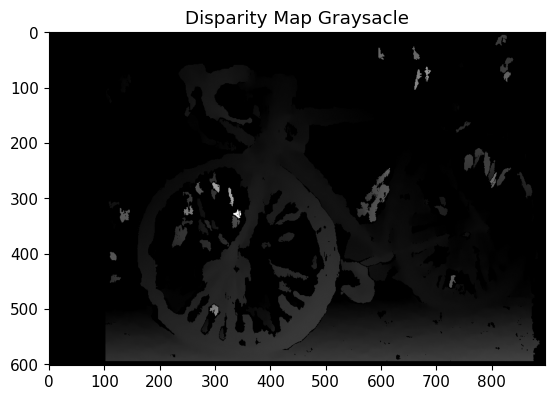

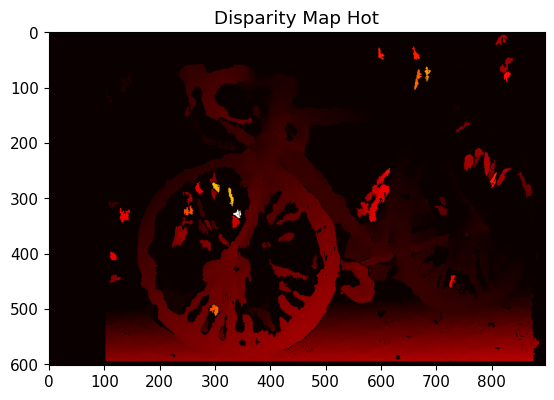

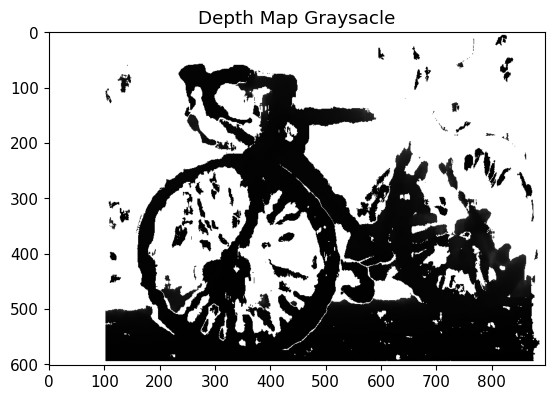

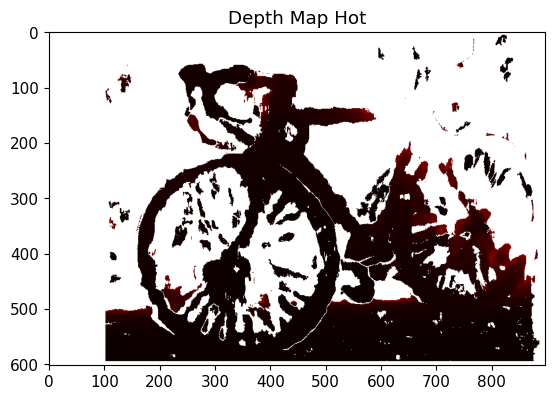

Sample depth values at center and corners:
Center: 0.16138375
Top-Left: 15.230591
Bottom-Right: 15.230591


Using cache found in C:\Users\rohit/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-7-8 Python-3.11.2 torch-2.2.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


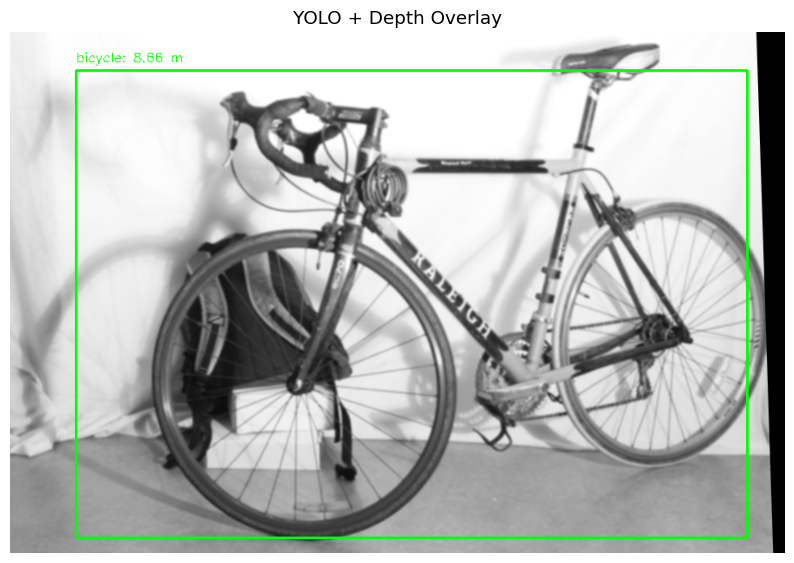

In [46]:
def main():
    number = int(input("Please enter the dataset number (1/2/3) to use for calculating the depth map\n"))
    img1 = cv2.imread(f"Dataset{number}/im0.png", 0)
    img2 = cv2.imread(f"Dataset{number}/im1.png", 0)

    # Scale factor for image resizing
    scale_factor = 0.3
    
    width = int(img1.shape[1] * scale_factor)
    height = int(img1.shape[0] * scale_factor)

    img1 = cv2.resize(img1, (width, height), interpolation=cv2.INTER_AREA)
    img1 = cv2.GaussianBlur(img1, (5, 5), 0)
    img2 = cv2.resize(img2, (width, height), interpolation=cv2.INTER_AREA)
    img2 = cv2.GaussianBlur(img2, (5, 5), 0)
    
    #__________________Camera Parameters (ORIGINAL)________________________________
    K11_orig = np.array([[5299.313,  0,   1263.818], 
                        [0,      5299.313, 977.763],
                        [0,          0,       1   ]])
    K12_orig = np.array([[5299.313,   0,    1438.004],
                        [0,      5299.313,  977.763 ],
                        [0,           0,      1     ]])

    K21_orig = np.array([[4396.869, 0, 1353.072],
                        [0, 4396.869, 989.702],
                        [0, 0, 1]])
    K22_orig = np.array([[4396.869, 0, 1538.86],
                        [0, 4396.869, 989.702],
                        [0, 0, 1]])
    
    K31_orig = np.array([[5806.559, 0, 1429.219],
                        [0, 5806.559, 993.403],
                        [ 0, 0, 1]])
    K32_orig = np.array([[5806.559, 0, 1543.51],
                        [ 0, 5806.559, 993.403],
                        [ 0, 0, 1]])

    # Scale camera parameters for resized images
    def scale_camera_matrix(K, scale):
        """Scale camera intrinsic matrix for resized images"""
        K_scaled = K.copy()
        K_scaled[0, 0] *= scale  # fx
        K_scaled[1, 1] *= scale  # fy  
        K_scaled[0, 2] *= scale  # cx
        K_scaled[1, 2] *= scale  # cy
        return K_scaled

    # Create scaled camera matrices
    K11 = scale_camera_matrix(K11_orig, scale_factor)
    K12 = scale_camera_matrix(K12_orig, scale_factor)
    K21 = scale_camera_matrix(K21_orig, scale_factor)
    K22 = scale_camera_matrix(K22_orig, scale_factor)
    K31 = scale_camera_matrix(K31_orig, scale_factor)
    K32 = scale_camera_matrix(K32_orig, scale_factor)
    
    camera_params = [(K11, K12), (K21, K22), (K31, K32)]

    while(1):
        try:
            list_kp1, list_kp2 = draw_keypoints_and_match(img1, img2)
            
            #_______________________________Calibration_______________________________

            F = RANSAC_F_matrix([list_kp1, list_kp2])
            print("F matrix", F)
            print("=="*20, '\n')
            K1, K2 = camera_params[number-1]  # Use scaled camera parameters
            E = calculate_E_matrix(F, K1, K2)
            print("E matrix", E)
            print("=="*20, '\n')
            camera_poses = extract_camerapose(E)
            best_camera_pose = disambiguate_camerapose(camera_poses, list_kp1)
            print("Best_Camera_Pose:")
            print("=="*20)
            print("Roatation", best_camera_pose[0])
            print()
            print("Transaltion", best_camera_pose[1])
            print("=="*20, '\n')
            pts1 = np.int32(list_kp1)
            pts2 = np.int32(list_kp2)

            #____________________________Rectification________________________________
            
            rectified_pts1, rectified_pts2, img1_rectified, img2_rectified = rectification(img1, img2, pts1, pts2, F)
            break
        except Exception as e:
            # print("error", e)
            continue
    
    # Find epilines corresponding to points in right image (second image) and drawing its lines on left image
    
    lines1 = cv2.computeCorrespondEpilines(rectified_pts2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    img5, img6 = drawlines(img1_rectified, img2_rectified, lines1, rectified_pts1, rectified_pts2)

    # Find epilines corresponding to points in left image (first image) and drawing its lines on right image

    lines2 = cv2.computeCorrespondEpilines(rectified_pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img3, img4 = drawlines(img2_rectified, img1_rectified, lines2, rectified_pts2, rectified_pts1)

    cv2.imwrite("left_image.png", img5)
    cv2.imwrite("right_image.png", img3)
    
    #____________________________Correspondance________________________________
    
    disparity_map_unscaled, disparity_map_scaled = ssd_correspondence(img1_rectified, img2_rectified)
    # cv2.imwrite(f"disparity_map_{number}.png", disparity_map_scaled)

    # img_n = cv2.normalize(src=disparity_map_scaled, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # heatmap1 = cv2.applyColorMap(img_n, cv2.COLORMAP_HOT)
    # cv2.imwrite(f"disparity_heat_map_{number}.png", heatmap1)
    plt.figure(1)
    plt.title('Disparity Map Graysacle')
    plt.imshow(disparity_map_scaled, cmap='gray')
    plt.figure(2)
    plt.title('Disparity Map Hot')
    plt.imshow(disparity_map_scaled, cmap='hot')
    

    #________________________________Depth______________________________________
    # baseline1, f1 = 177.288, 5299.313
    # baseline2, f2 = 144.049, 4396.869
    # baseline3, f3 = 174.019, 5806.559
    
    # params = [(baseline1, f1), (baseline2, f2), (baseline3, f3)]
    # baseline, f = params[number-1]
    # depth_map, depth_array = disparity_to_depth(baseline, f, disparity_map_unscaled)
    #________________________________Depth______________________________________

    # Calculate baseline from camera parameters (pixel baseline method)
    camera_params_orig = [(K11_orig, K12_orig), (K21_orig, K22_orig), (K31_orig, K32_orig)]
    K1_orig, K2_orig = camera_params_orig[number-1]
    pixel_baseline = abs(K2_orig[0, 2] - K1_orig[0, 2])  # |cx2 - cx1|

    # Method 1: Calculate physical baseline from pixel baseline
    pixel_size_meters = 5.5e-6  # 5.5 micrometers (typical camera sensor)
    baseline_calculated = pixel_baseline * pixel_size_meters

    # Method 2: Use your provided values as mm
    baselines_mm = [177.288, 144.049, 174.019]
    baseline_provided = baselines_mm[number - 1] / 1000  # convert mm to meters

    # Get scaled focal length (use the scaled camera parameters)
    K1_scaled, K2_scaled = camera_params[number-1]
    f_scaled = K1_scaled[0, 0]  # Already scaled

    print(f"\n[DEBUG] Dataset {number} parameters:")
    print(f"Pixel baseline: {pixel_baseline:.3f} pixels")
    print(f"Calculated baseline: {baseline_calculated:.6f} m ({baseline_calculated*1000:.3f} mm)")
    print(f"Provided baseline: {baseline_provided:.6f} m ({baseline_provided*1000:.3f} mm)")
    print(f"Focal length (scaled): {f_scaled:.2f} px")

    # Choose which baseline to use (start with provided, switch to calculated if needed)
    use_calculated = True  # Change to True to test calculated baseline

    if use_calculated:
        baseline = baseline_calculated
        print(f"Using CALCULATED baseline: {baseline:.6f} m")
    else:
        baseline = baseline_provided
        print(f"Using PROVIDED baseline: {baseline:.6f} m")

    # Keep the original variable name for compatibility
    f_scaled = f_scaled  # This is already the scaled focal length

    print(f"[INFO] Using baseline = {baseline:.3f} m, scaled focal length = {f_scaled:.2f} px")

    # Compute depth
    depth_map, depth_array = disparity_to_depth(baseline, f_scaled, disparity_map_unscaled)

    # Add depth statistics for debugging
    valid_depths = depth_array[depth_array > 0]
    if len(valid_depths) > 0:
        print(f"\n[DEPTH STATS]")
        print(f"Min depth: {np.min(valid_depths):.3f} m")
        print(f"Max depth: {np.max(valid_depths):.3f} m")
        print(f"Mean depth: {np.mean(valid_depths):.3f} m")
        print(f"Median depth: {np.median(valid_depths):.3f} m")
        
        # Check for reasonable depth range
        reasonable = valid_depths[(valid_depths > 0.1) & (valid_depths < 100)]
        print(f"Reasonable depths (0.1-100m): {len(reasonable)}/{len(valid_depths)} pixels")
        
        if len(reasonable) < len(valid_depths) * 0.5:
            print("WARNING: Less than 50% of depths are reasonable!")
            print("Try changing 'use_calculated' to True/False to test different baseline methods.")
    else:
        print("ERROR: No valid depths calculated!")

    plt.figure(3)
    plt.title('Depth Map Graysacle')
    plt.imshow(depth_map, cmap='gray')
    plt.figure(4)
    plt.title('Depth Map Hot')
    plt.imshow(depth_map, cmap='hot')
    plt.show()
    
    print("Sample depth values at center and corners:")
    h, w = depth_array.shape
    print("Center:", depth_array[h//2, w//2])
    print("Top-Left:", depth_array[10, 10])
    print("Bottom-Right:", depth_array[h-10, w-10])

    print("=="*20)
    #print("Depth values", depth_array)

    #____________________________________________________________________________
    # ------------------- YOLO + Depth Overlay -------------------

    # Load YOLOv5 model
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

    # Convert to RGB for YOLO
    if len(img1_rectified.shape) == 2:  # Grayscale
        img_rgb = cv2.cvtColor(img1_rectified, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2RGB)
        
    results = model(img_rgb)
    detections = results.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2, conf, class]

    # Annotate and display
    output_img = img1_rectified.copy()
    
    # Convert to color for annotations if needed
    if len(output_img.shape) == 2:  # Grayscale
        output_img = cv2.cvtColor(output_img, cv2.COLOR_GRAY2BGR)

    for det in detections:
        x1, y1, x2, y2, conf, cls_id = det[:6]
        
        # Filter by confidence
        if conf < 0.5:
            continue
            
        x1, y1, x2, y2, cls_id = map(int, [x1, y1, x2, y2, cls_id])
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, depth_array.shape[1]-1), min(y2, depth_array.shape[0]-1)

        roi = depth_array[y1:y2, x1:x2]
        valid_depths = roi[roi > 0]

        if valid_depths.size > 0:
            avg_depth = np.mean(valid_depths)
        else:
            avg_depth = 0

        label = f"{model.names[cls_id]}: {avg_depth:.2f} m"
        cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(output_img, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Show final output
    output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

    # Show image inline
    plt.figure(figsize=(10, 8))
    plt.imshow(output_img_rgb)
    plt.title("YOLO + Depth Overlay")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

In [47]:
# def main():
#     number = int(input("Please enter the dataset number (1/2/3) to use for calculating the depth map\n"))
#     img1 = cv2.imread(f"Dataset{number}/im0.png", 0)
#     img2 = cv2.imread(f"Dataset{number}/im1.png", 0)

#     width = int(img1.shape[1]* 0.3) # 0.3
#     height = int(img1.shape[0]* 0.3) # 0.3

#     img1 = cv2.resize(img1, (width, height), interpolation = cv2.INTER_AREA)
#     img1 = cv2.GaussianBlur(img1,(5,5),0)
#     img2 = cv2.resize(img2, (width, height), interpolation = cv2.INTER_AREA)
#     img2 = cv2.GaussianBlur(img2,(5,5),0)
    
#     #__________________Camera Parameters________________________________
#     K11 = np.array([[5299.313,  0,   1263.818], 
#                 [0,      5299.313, 977.763],
#                 [0,          0,       1   ]])
#     K12 = np.array([[5299.313,   0,    1438.004],
#                 [0,      5299.313,  977.763 ],
#                 [0,           0,      1     ]])

#     K21 = np.array([[4396.869, 0, 1353.072],
#                     [0, 4396.869, 989.702],
#                     [0, 0, 1]])
#     K22 = np.array([[4396.869, 0, 1538.86],
#                 [0, 4396.869, 989.702],
#                 [0, 0, 1]])
    
#     K31 = np.array([[5806.559, 0, 1429.219],
#                     [0, 5806.559, 993.403],
#                     [ 0, 0, 1]])
#     K32 = np.array([[5806.559, 0, 1543.51],
#                     [ 0, 5806.559, 993.403],
#                     [ 0, 0, 1]])
#     camera_params = [(K11, K12), (K21, K22), (K31, K32)]

#     while(1):
#         try:
#             list_kp1, list_kp2 = draw_keypoints_and_match(img1, img2)
            
#             #_______________________________Calibration_______________________________

#             F = RANSAC_F_matrix([list_kp1, list_kp2])
#             print("F matrix", F)
#             print("=="*20, '\n')
#             K1, K2 = camera_params[number-1]
#             E = calculate_E_matrix(F, K1, K2)
#             print("E matrix", E)
#             print("=="*20, '\n')
#             camera_poses = extract_camerapose(E)
#             best_camera_pose = disambiguate_camerapose(camera_poses, list_kp1)
#             print("Best_Camera_Pose:")
#             print("=="*20)
#             print("Roatation", best_camera_pose[0])
#             print()
#             print("Transaltion", best_camera_pose[1])
#             print("=="*20, '\n')
#             pts1 = np.int32(list_kp1)
#             pts2 = np.int32(list_kp2)

#             #____________________________Rectification________________________________
            
#             rectified_pts1, rectified_pts2, img1_rectified, img2_rectified = rectification(img1, img2, pts1, pts2, F)
#             break
#         except Exception as e:
#             # print("error", e)
#             continue
    
#     # Find epilines corresponding to points in right image (second image) and drawing its lines on left image
    
#     lines1 = cv2.computeCorrespondEpilines(rectified_pts2.reshape(-1, 1, 2), 2, F)
#     lines1 = lines1.reshape(-1, 3)
#     img5, img6 = drawlines(img1_rectified, img2_rectified, lines1, rectified_pts1, rectified_pts2)

#     # Find epilines corresponding to points in left image (first image) and drawing its lines on right image

#     lines2 = cv2.computeCorrespondEpilines(rectified_pts1.reshape(-1, 1, 2), 1, F)
#     lines2 = lines2.reshape(-1, 3)
#     img3, img4 = drawlines(img2_rectified, img1_rectified, lines2, rectified_pts2, rectified_pts1)

#     cv2.imwrite("left_image.png", img5)
#     cv2.imwrite("right_image.png", img3)
    
#     #____________________________Correspondance________________________________
    
#     disparity_map_unscaled, disparity_map_scaled = ssd_correspondence(img1_rectified, img2_rectified)
#     # cv2.imwrite(f"disparity_map_{number}.png", disparity_map_scaled)

#     # img_n = cv2.normalize(src=disparity_map_scaled, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     # heatmap1 = cv2.applyColorMap(img_n, cv2.COLORMAP_HOT)
#     # cv2.imwrite(f"disparity_heat_map_{number}.png", heatmap1)
#     plt.figure(1)
#     plt.title('Disparity Map Graysacle')
#     plt.imshow(disparity_map_scaled, cmap='gray')
#     plt.figure(2)
#     plt.title('Disparity Map Hot')
#     plt.imshow(disparity_map_scaled, cmap='hot')
    

#     #________________________________Depth______________________________________
#     # baseline1, f1 = 177.288, 5299.313
#     # baseline2, f2 = 144.049, 4396.869
#     # baseline3, f3 = 174.019, 5806.559
    
#     # params = [(baseline1, f1), (baseline2, f2), (baseline3, f3)]
#     # baseline, f = params[number-1]
#     # depth_map, depth_array = disparity_to_depth(baseline, f, disparity_map_unscaled)
#     #________________________________Depth______________________________________
#     scale_factor = 0.3

#     # Dataset-specific baseline (mm → meters) and original focal length
#     baselines_mm = [177.288, 144.049, 174.019]
#     focals_px = [5299.313, 4396.869, 5806.559]

#     # Select based on dataset
#     baseline = baselines_mm[number - 1] / 1000  # convert mm → meters
#     f_scaled = focals_px[number - 1] * scale_factor  # scale for resized image

#     print(f"[INFO] Using baseline = {baseline:.3f} m, scaled focal length = {f_scaled:.2f} px")

#     # Compute depth
#     depth_map, depth_array = disparity_to_depth(baseline, f_scaled, disparity_map_unscaled)

    
#     plt.figure(3)
#     plt.title('Depth Map Graysacle')
#     plt.imshow(depth_map, cmap='gray')
#     plt.figure(4)
#     plt.title('Depth Map Hot')
#     plt.imshow(depth_map, cmap='hot')
#     plt.show()
    
#     print("Sample depth values at center and corners:")
#     h, w = depth_array.shape
#     print("Center:", depth_array[h//2, w//2])
#     print("Top-Left:", depth_array[10, 10])
#     print("Bottom-Right:", depth_array[h-10, w-10])

#     print("=="*20)
#     #print("Depth values", depth_array)

#     #____________________________________________________________________________
#            # ------------------- YOLO + Depth Overlay -------------------


#     # Load YOLOv5 model
#     model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

#     # Convert to RGB for YOLO
#     img_rgb = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2RGB)
#     results = model(img_rgb)
#     detections = results.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2, conf, class]

#     # Annotate and display
#     output_img = img1_rectified.copy()

#     for det in detections:
#         x1, y1, x2, y2, conf, cls_id = map(int, det[:6])
#         x1, y1 = max(x1,0), max(y1,0)
#         x2, y2 = min(x2, depth_array.shape[1]-1), min(y2, depth_array.shape[0]-1)

#         roi = depth_array[y1:y2, x1:x2]
#         valid_depths = roi[roi > 0]

#         if valid_depths.size > 0:
#             avg_depth = np.mean(valid_depths)
#         else:
#             avg_depth = 0

#         label = f"{model.names[cls_id]}: {avg_depth:.2f} m"
#         cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
#         cv2.putText(output_img, label, (x1, y1 - 10),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

#     # Show final output
#     cv2.imshow("YOLO + Depth", output_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    

# if __name__ == "__main__":
#     main()

In [48]:
# def main():
#     number = int(input("Please enter the dataset number (1/2/3) to use for calculating the depth map\n"))
#     img1 = cv2.imread(f"Dataset{number}/im0.png", 0)
#     img2 = cv2.imread(f"Dataset{number}/im1.png", 0)

#     width = int(img1.shape[1]* 0.3) # 0.3
#     height = int(img1.shape[0]* 0.3) # 0.3

#     img1 = cv2.resize(img1, (width, height), interpolation = cv2.INTER_AREA)
#     # img1 = cv2.GaussianBlur(img1,(5,5),0)
#     img2 = cv2.resize(img2, (width, height), interpolation = cv2.INTER_AREA)
#     # img2 = cv2.GaussianBlur(img2,(5,5),0)
    
#     # Scale factor for camera parameters
#     scale_factor = 0.3
    
#     #__________________Camera Parameters________________________________
#     K11 = np.array([[5299.313,  0,   1263.818], 
#                 [0,      5299.313, 977.763],
#                 [0,          0,       1   ]])
#     K12 = np.array([[5299.313,   0,    1438.004],
#                 [0,      5299.313,  977.763 ],
#                 [0,           0,      1     ]])

#     K21 = np.array([[4396.869, 0, 1353.072],
#                     [0, 4396.869, 989.702],
#                     [0, 0, 1]])
#     K22 = np.array([[4396.869, 0, 1538.86],
#                 [0, 4396.869, 989.702],
#                 [0, 0, 1]])
    
#     K31 = np.array([[5806.559, 0, 1429.219],
#                     [0, 5806.559, 993.403],
#                     [ 0, 0, 1]])
#     K32 = np.array([[5806.559, 0, 1543.51],
#                     [ 0, 5806.559, 993.403],
#                     [ 0, 0, 1]])
#     camera_params = [(K11, K12), (K21, K22), (K31, K32)]

#     while(1):
#         try:
#             list_kp1, list_kp2 = draw_keypoints_and_match(img1, img2)
            
#             #_______________________________Calibration_______________________________

#             F = RANSAC_F_matrix([list_kp1, list_kp2])
#             print("F matrix", F)
#             print("=="*20, '\n')
            
#             # Scale camera parameters for resized images
#             K1_orig, K2_orig = camera_params[number-1]
#             K1 = K1_orig.copy()
#             K2 = K2_orig.copy()
#             K1[0, 0] *= scale_factor  # fx
#             K1[1, 1] *= scale_factor  # fy
#             K1[0, 2] *= scale_factor  # cx
#             K1[1, 2] *= scale_factor  # cy
#             K2[0, 0] *= scale_factor  # fx
#             K2[1, 1] *= scale_factor  # fy
#             K2[0, 2] *= scale_factor  # cx
#             K2[1, 2] *= scale_factor  # cy
            
#             E = calculate_E_matrix(F, K1, K2)
#             print("E matrix", E)
#             print("=="*20, '\n')
#             camera_poses = extract_camerapose(E)
#             best_camera_pose = disambiguate_camerapose(camera_poses, list_kp1)
#             print("Best_Camera_Pose:")
#             print("=="*20)
#             print("Roatation", best_camera_pose[0])
#             print()
#             print("Transaltion", best_camera_pose[1])
#             print("=="*20, '\n')
#             pts1 = np.int32(list_kp1)
#             pts2 = np.int32(list_kp2)

#             #____________________________Rectification________________________________
            
#             rectified_pts1, rectified_pts2, img1_rectified, img2_rectified = rectification(img1, img2, pts1, pts2, F)
#             break
#         except Exception as e:
#             # print("error", e)
#             continue
    
#     # Find epilines corresponding to points in right image (second image) and drawing its lines on left image
    
#     lines1 = cv2.computeCorrespondEpilines(rectified_pts2.reshape(-1, 1, 2), 2, F)
#     lines1 = lines1.reshape(-1, 3)
#     img5, img6 = drawlines(img1_rectified, img2_rectified, lines1, rectified_pts1, rectified_pts2)

#     # Find epilines corresponding to points in left image (first image) and drawing its lines on right image

#     lines2 = cv2.computeCorrespondEpilines(rectified_pts1.reshape(-1, 1, 2), 1, F)
#     lines2 = lines2.reshape(-1, 3)
#     img3, img4 = drawlines(img2_rectified, img1_rectified, lines2, rectified_pts2, rectified_pts1)

#     cv2.imwrite("left_image.png", img5)
#     cv2.imwrite("right_image.png", img3)
    
#     #____________________________Correspondance________________________________
    
#     disparity_map_unscaled, disparity_map_scaled = ssd_correspondence(img1_rectified, img2_rectified)
#     # cv2.imwrite(f"disparity_map_{number}.png", disparity_map_scaled)

#     # img_n = cv2.normalize(src=disparity_map_scaled, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     # heatmap1 = cv2.applyColorMap(img_n, cv2.COLORMAP_HOT)
#     # cv2.imwrite(f"disparity_heat_map_{number}.png", heatmap1)
#     # Display disparity and depth maps in notebook
#     plt.figure(figsize=(15, 10))
    
#     plt.subplot(2, 3, 1)
#     plt.title('Disparity Map Grayscale')
#     plt.imshow(disparity_map_scaled, cmap='gray')
#     plt.colorbar()
    
#     plt.subplot(2, 3, 2)
#     plt.title('Disparity Map Hot')
#     plt.imshow(disparity_map_scaled, cmap='hot')
#     plt.colorbar()
    

#     #________________________________Depth______________________________________
#     baseline1, f1 = 177.288, 5299.313
#     baseline2, f2 = 144.049, 4396.869
#     baseline3, f3 = 174.019, 5806.559
    
#     params = [(baseline1, f1), (baseline2, f2), (baseline3, f3)]
#     baseline_orig, f_orig = params[number-1]
#     # Scale baseline and focal length for resized images
#     baseline = baseline_orig * scale_factor
#     f = f_orig * scale_factor
#     depth_map, depth_array = disparity_to_depth(baseline, f, disparity_map_unscaled)
    
#     plt.subplot(2, 3, 3)
#     plt.title('Depth Map Grayscale')
#     plt.imshow(depth_map, cmap='gray')
#     plt.colorbar()
    
#     plt.subplot(2, 3, 4)
#     plt.title('Depth Map Hot')
#     plt.imshow(depth_map, cmap='hot')
#     plt.colorbar()
    
#     plt.subplot(2, 3, 5)
#     plt.title('Original Image 1')
#     plt.imshow(img1_rectified, cmap='gray')
    
#     plt.subplot(2, 3, 6)
#     plt.title('Original Image 2')
#     plt.imshow(img2_rectified, cmap='gray')
    
#     plt.tight_layout()
#     plt.show()
    
#     print("Debug info:")
#     print(f"Disparity range: {np.min(disparity_map_unscaled):.2f} to {np.max(disparity_map_unscaled):.2f}")
#     print(f"Depth range: {np.min(depth_array):.2f} to {np.max(depth_array):.2f} meters")
#     print()
    
#     print("Sample depth values at center and corners:")
#     h, w = depth_array.shape
#     print("Center:", depth_array[h//2, w//2])
#     print("Top-Left:", depth_array[10, 10])
#     print("Bottom-Right:", depth_array[h-10, w-10])

#     print("=="*20)
#     #print("Depth values", depth_array)

#     #____________________________________________________________________________
#            # ------------------- YOLO + Depth Overlay -------------------


#     # Load YOLOv5 model
#     model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

#     # Convert to RGB for YOLO
#     img_rgb = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2RGB)
#     results = model(img_rgb)
#     detections = results.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2, conf, class]

#     # Annotate and display
#     output_img = img1_rectified.copy()

#     # for det in detections:
#     #     x1, y1, x2, y2, conf, cls_id = map(int, det[:6])
#     #     x1, y1 = max(x1,0), max(y1,0)
#     #     x2, y2 = min(x2, depth_array.shape[1]-1), min(y2, depth_array.shape[0]-1)

#     #     roi = depth_array[y1:y2, x1:x2]
#     #     valid_depths = roi[roi > 0]

#     #     if valid_depths.size > 0:
#     #         avg_depth = np.mean(valid_depths)
#     #     else:
#     #         avg_depth = 0

#     #     label = f"{model.names[cls_id]}: {avg_depth:.2f} m"
#     #     cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
#     #     cv2.putText(output_img, label, (x1, y1 - 10),
#     #                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
#     for det in detections:
#         x1, y1, x2, y2, conf, cls_id = map(int, det[:6])

#         # Clamp coordinates
#         x1, y1 = max(x1, 0), max(y1, 0)
#         x2, y2 = min(x2, depth_array.shape[1] - 1), min(y2, depth_array.shape[0] - 1)

#         # Compute center of bounding box
#         cx = (x1 + x2) // 2
#         cy = (y1 + y2) // 2

#         # Ensure center is within image bounds
#         cx = min(max(cx, 0), depth_array.shape[1] - 1)
#         cy = min(max(cy, 0), depth_array.shape[0] - 1)

#         # Get depth at center
#         depth_at_center = depth_array[cy, cx]

#         if depth_at_center <= 0 or np.isnan(depth_at_center):
#             label = f"{model.names[cls_id]}: N/A"
#         else:
#             label = f"{model.names[cls_id]}: {depth_at_center:.2f} m"

#         # Draw rectangle and label
#         cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
#         cv2.putText(output_img, label, (x1, y1 - 10),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

#         # Optional: draw center point
#         cv2.circle(output_img, (cx, cy), 3, (0, 0, 255), -1)
     

#     # Display YOLO + Depth result in notebook
#     plt.figure(figsize=(12, 8))
    
#     # Convert BGR to RGB for proper display in matplotlib
#     output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    
#     plt.imshow(output_img_rgb)
#     plt.title('YOLO Object Detection with Depth Information')
#     plt.axis('off')
#     plt.show()
#     %matplotlib inline
    
#     print("Processing complete! All visualizations displayed above.")

    

# if __name__ == "__main__":
#     main()